In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torch
import wandb
import os
from Util import *
from tqdm import tqdm
from RBM import *
import matplotlib

In [2]:
# N.B. don't apply one-hot encoding on labels - we don't need them (unsupervised learning)
# Applying ToTensor() transform to change type(data) to torch.Tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_transform_1 = torchvision.transforms.ToTensor()
my_transforms = torchvision.transforms.Compose([my_transform_1])

# Set download=True first time to acquire dataset
_MNIST_DATASET = torchvision.datasets.MNIST(root="data/",
                                            download=False,
                                            train=True,
                                            transform=my_transforms)

# Picking out numbers from dataset
numbers = [2]
_MNIST_DATASET.data = _MNIST_DATASET.data[keep_numbers(numbers,_MNIST_DATASET)][:1000]
_MNIST_DATASET.targets = _MNIST_DATASET.targets[keep_numbers(numbers,_MNIST_DATASET)][:1000]
print("nr. datapoints: ",_MNIST_DATASET.data.__len__())

# Transforming to binary
DATA = []
for datapoint in range(_MNIST_DATASET.data.__len__()):
    DATA.append(torch.round((_MNIST_DATASET.data[datapoint]/255)).numpy().flatten().tolist())
DATA = torch.tensor(DATA,device=device)

nr. datapoints:  1000


Initial map: 


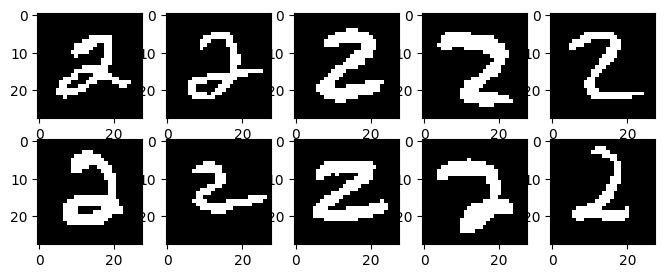

In [3]:
print("Initial map: ")
rows = 2
cols = 5
fig, ax = plt.subplots(rows,cols, figsize= (8,3))
counter = 0
for row in range(rows):
    for col in range(cols):
        X_hat = DATA[counter].reshape((28,28)).detach().numpy()
        ax[row][col].imshow(X_hat, cmap="gray")

        counter += 1
plt.show()

In [4]:
_hidden_units = int(DATA[0].shape[0] / 1.5)
_visible_units = DATA[0].shape[0]

my_RBM = RestrictedBoltzmannMachine(hidden_units=_hidden_units,
                                    visible_units=_visible_units)

In [5]:
my_RBM.train_network(dataset=DATA,lr=0.005,epochs=200,batch_size=50,k=100)

Using device:  cpu


100%|██████████| 200/200 [06:48<00:00,  2.04s/it]


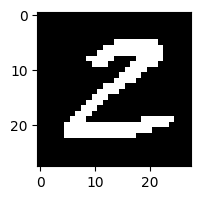

In [6]:

datapoint = DATA[12].reshape((_visible_units,1))
fig, ax = plt.subplots(1,1, figsize= (2,2))
_sample = my_RBM.gibbs_sample(datapoint,steps=1)
ax.imshow(datapoint.reshape((28,28)).detach().numpy(), cmap="gray")
plt.show()


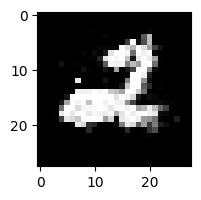

In [17]:
fig, ax = plt.subplots(1,1, figsize= (2,2))
steps = 100
for i in range(steps):
    P_h_t = torch.sigmoid(my_RBM.visible_to_hidden(visible=datapoint))
    # Sampling h_t ~ P(h_t|v_t)
    _h_t = my_RBM.sample(P_h_t)
    # Getting P(v_t|h_t)
    P_v_t = torch.sigmoid(my_RBM.hidden_to_visible(hidden=_h_t))
     # Sampling v_t ~ P(h_t|v_t)
    datapoint = my_RBM.sample(P_v_t)
ax.imshow(P_v_t.reshape((28,28)).detach().numpy(), cmap="gray")
plt.show()

In [20]:
def save_image_grid_2(images: torch.Tensor, epoch: int):
    _rows = 6
    _cols = 6
    _fig, _ax = plt.subplots(_rows, _cols, figsize= (8,8))
    counter = 0
    for _row in range(_rows):
        for _col in range(_cols):
            _X_hat = images[counter].reshape((28,28)).detach().numpy()
            _ax[_row][_col].set_xticks([])
            _ax[_row][_col].set_yticks([])
            plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0,hspace=0)
            _ax[_row][_col].imshow(_X_hat, cmap="gray")
            counter += 1
    plt.savefig("Training_pictures/epoch_"+str(epoch)+".png")
    plt.close()


counter = 0
for epoch in tqdm(range(len(my_RBM.history))):
    if counter % 5 == 0:
        save_image_grid_2(images=my_RBM.history[epoch],epoch=epoch)
    counter += 1

100%|██████████| 200/200 [00:18<00:00, 10.64it/s]
